# COMP47670 Assignment 1: Data Collection & Preparation


#### Student Name: Dara Leonard
#### Student ID: 19202478

In [32]:
import gmplot
import matplotlib.pyplot as plt
import pandas as pd
import requests
from stravalib import Client 

#### Task 1: Identify one or more suitable web APIs

Two web APIs have been identified to investigate if the weather in a certain location has an impact on the top time on a
segment on Strava. A segment is a portion of road or trail created by members where athletes can compare times. For the sake
of this project, I am only focusing on running segments. This can easily be changed to look for cycling segments by changing
the 'activity_type' in the 'explore_segments' API call to 'riding'.

Any area can be scanned for segments by entering the latitude and longitude (South-West and North-East
corners) of said area. Due to a limitation of the Strava API, a limit of 10 segments in an area can be returned. The
Strava API is openly available and allows for requests to be made for public data and data specific to an individual
athlete. The access token is refreshed daily. 'stravalib' is used in this project and is a python library for interacting
with version 3 of the Strava API. [Documention for stravalib can be found here.](https://pythonhosted.org/stravalib/)

The World Weather Online offers an API for historic weather that can be queried with latitude and longitude. It also offers
an API that provided the climate for an area based on the previous seven years of weather. These APIs are not freely
available but there is a free 60 day trial upon signing up.

World Weather Online has a number of useful APIs for gathering weather data, two of which were used in this project:

[LOCAL WEATHER API](https://www.worldweatheronline.com/developer/api/docs/local-city-town-weather-api.aspx)
This API was used to get climate data for a specified location, averaged over the last 12 years.

[HISTORICAL OR PAST WEATHER API](https://www.worldweatheronline.com/developer/api/docs/historical-weather-api.aspx)
This API was used to get the weather on the specific days that a record was set on a Strava segment.


This project is available publicly [on my personal GitHub page](https://github.com/DaraLeonard/COMP47670-assignment1)

Set API keys for making requests

In [33]:
strava_client = Client(access_token='STRAVA API TOKEN HERE')

weather_api_key = 'World Weather Online API TOKEN HERE'

The next two functions are building the request URL for the requests to be made to the World Weather Online APIs. Since
I am using the stravalib python library, the equivalent method is not needed for building the Strava API requests.

In [34]:
def build_past_weather_request(location, year, month, day):
    return 'http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=' + weather_api_key + '&q='+ location +'&format=json&date='+ str(year) + '-' + str(month) + '-' + str(day)

def build_climate_request(location):
    return 'http://api.worldweatheronline.com/premium/v1/weather.ashx?key=' + weather_api_key + '&q='+ location + '&format=json&mca=yes'

#### Task 2: Collect data your chosen API(s)
The following four functions execute calls to the three identified APIs. At the end of this function, there are three
Pandas DataFrames that contain all of the data collected from the three API calls.

###### segment_info_df_final
This DataFrame contains all of the Strava segment data retrieved from the API. 

###### weather_data_df_final
This DataFrame contains data on the weather in the area of a segment on the day that the best segment time was set.

###### climate_data_df_final
This DataFrame contains data on the climate of the area specified over the previous 12 years. 


Set the North-East and South-West corners of your segment search area

In [35]:
sw_lat = 53.263329
sw_lng = -9.070642
ne_lat = 53.283310
ne_lng = -9.044810

In [36]:
def execute_strava_requests():
    segments_in_an_area = strava_client.explore_segments(bounds=[sw_lat, sw_lng, ne_lat, ne_lng], activity_type='running') # Get current athlete details
    return [strava_client.get_segment(segment.id) for segment in segments_in_an_area]
 
def execute_weather_request(link):
    response = requests.get(link)
    json_res = response.json()['data']['weather']
    return json_res

def execute_historical_climate_request(link):
    response = requests.get(link)
    json_res = response.json()['data']['ClimateAverages']
    return json_res

def execute_api_requests(segment_info):
    weather_data_columns = ['date', 'astronomy', 'maxtempC','maxtempF','mintempC','mintempF','avgtempC', 'avgtempF', 'totalSnow_cm', 'sunHour', 'uvIndex', 'hourly']
    weather_data_df = pd.DataFrame(columns=weather_data_columns)
    
    climate_data_columns = ['start_latitude', 'start_longitude', 'month']
    climate_data_df = pd.DataFrame(columns=climate_data_columns)
    
    segment_info_columns = ['id', 'name', 'activity_type', 'distance', 'start_latitude', 'start_longitude', 'end_latitude',
           'end_longitude', 'city', 'state', 'country', 'hazardous', 'map_id', 'map_polyline', 'effort_count',
           'athlete_count', 'star_count', 'best_time', 'best_time_date']
    segment_info_df = pd.DataFrame(columns=segment_info_columns)
    for i, segment in enumerate(segment_info):
        segment_leader_board = strava_client.get_segment_leaderboard(segment.id)
        best_time = segment_leader_board.entries[0].elapsed_time
        best_time_date = segment_leader_board.entries[0].start_date
        strava_tmp = dict({'id': segment.id,
             'name': segment.name,
             'activity_type': segment.activity_type,
             'distance': segment.distance,
             'start_latitude': segment.start_latitude,
             'start_longitude': segment.start_longitude,
             'end_latitude': segment.end_latitude,
             'end_longitude': segment.end_longitude,
             'city': segment.city,
             'state': segment.state,
             'country': segment.country,
             'hazardous': segment.hazardous,
             'map_id': segment.map.id,
             'map_polyline': segment.map.polyline,
             'effort_count': segment.effort_count,
             'athlete_count': segment.athlete_count,
             'star_count': segment.star_count,
             'best_time' : best_time, 
             'best_time_date' : best_time_date})
        
        
        # The following try/catch block is necessary as the latitude and longitude returned from the Strava API is not 
        # always in the correct format, or is not set. Here we try the returned latitude and longitude and if it is not in 
        # the correct format for the World Weather Online API, we fall back to the input coordinates for the North-East
        # and South-West corners. This decision was made to prevent errors and missing data.

        try:
            weather_data = execute_weather_request(build_past_weather_request(str(segment.start_latitude + segment.start_longitude), best_time_date.year, best_time_date.month, best_time_date.day))
            tmp_lat = sw_lat
            tmp_long = sw_lng
        except (KeyError, TypeError):
            weather_data = execute_weather_request(build_past_weather_request(str(sw_lat + sw_lng), best_time_date.year, best_time_date.month, best_time_date.day))
            tmp_lat = sw_lat
            tmp_long = sw_lng
        
        strava_tmp['start_latitude'] = tmp_lat
        strava_tmp['start_longitude'] = tmp_long
        segment_info_df.loc[i] = strava_tmp

        weather_tmp = dict({'date' : weather_data[0].get('date'),
                    'astronomy' : weather_data[0].get('astronomy'),
                    'maxtempC': weather_data[0].get('maxtempC'),
                    'maxtempF': weather_data[0].get('maxtempF'),
                    'mintempC': weather_data[0].get('mintempC'),
                    'mintempF': weather_data[0].get('mintempF'),
                    'avgtempC': weather_data[0].get('avgtempC'),
                    'avgtempF': weather_data[0].get('avgtempF'),
                    'totalSnow_cm': weather_data[0].get('totalSnow_cm'), 
                    'sunHour': weather_data[0].get('sunHour'), 
                    'uvIndex': weather_data[0].get('uvIndex'), 
                    'hourly': weather_data[0].get('hourly')})
        weather_data_df.loc[i] = weather_tmp

        climate_data = execute_historical_climate_request(build_climate_request(str(tmp_lat + tmp_long)))

        climate_tmp = dict({
            'start_latitude' : segment.start_latitude,
            'start_longitude' : segment.start_longitude,
            'month' : climate_data
        })
        climate_data_df.loc[i] = climate_tmp

    return segment_info_df, weather_data_df, climate_data_df


segment_info_final = execute_strava_requests()
segment_info_df_final, weather_data_df_final, climate_data_df_final = execute_api_requests(segment_info_final)

#### Task 3: Parse the collected data, and store it in an appropriate file format
The following code dumps each of the DataFrames to a JSON file. The data is reasonably structured before it is dumped to
a JSON file, but still needs to be cleaned and the useful data extracted.

In [37]:
segment_info_df_final.to_json('strava-data.json', orient='records')
weather_data_df_final.to_json('weather-data.json', orient='records')
climate_data_df_final.to_json('climate-data.json', orient='records')

#### Task 4: Load and represent the data using an appropriate data structure. Apply any pre-processing steps to clean/filter/combine the data
Data is read from the JSON files into DataFrames

In [47]:
strava_data = pd.read_json('strava-data.json', orient='records')
weather_data = pd.read_json('weather-data.json', orient='records')
climate_data = pd.read_json('climate-data.json', orient='records')

Data necessary to carry out analysis is identified and extracted. The next three functions carry out data manipulation
to extract all the data identified to perform analysis.

A new Dataframe (consolidated_df) is then constructed with the identified data from each of the three DataFrames.

In [48]:
def get_temp_wind_and_rain(pos, rounded_time_value):
    for hour in weather_data['hourly'][pos]:
        if str(hour.get('time')) == str(rounded_time_value):
            return hour.get('tempC'), hour.get('windspeedKmph'), hour.get('precipMM')

def round_to_nearest_300(x, base=300):
    return base * round(x/base)

def get_month_int(pos):
    return int(str(pd.to_datetime(strava_data['best_time_date'][pos], unit='ms').date()).split('-')[1])

def get_average_precipitation_and_average_min_temp(pos):
    for month in climate_data['month'][0]:
        return month.get('month')[pos-1].get('avgMinTemp'), month.get('month')[pos-1].get('avgDailyRainfall')

consolidated_data_columns = ['Segment Name', 'City', 'Start Latitude', 'Start Longitude', 'Distance (m)', 'Time Taken (s)', 'Speed (m/s)', 'Date', 'Finish Time (Time of Day)', 'Rain that Hour (mm)', 'Wind that Hour (km/hr)', 'Temperature that Hour (C)', 'Average Rainfall (mm/hr)', 'Average Temperature (C)']
consolidated_df = pd.DataFrame(columns=consolidated_data_columns)

for i in strava_data.index:
    rounded_best_time_value = round_to_nearest_300(int(str(pd.to_datetime(strava_data['best_time_date'][i], unit='ms').time()).replace(':', '')[:-2]))
    temp, wind_speed, precipitation = get_temp_wind_and_rain(i, rounded_best_time_value)
    avrg_tmp, avrg_rain = get_average_precipitation_and_average_min_temp(get_month_int(i))

    tmp_consolidated_data = dict({
        'Segment Name' : strava_data['name'][i],
        'City' : strava_data['city'][i],
        'Start Latitude' : strava_data['start_latitude'][i],
        'Start Longitude' : strava_data['start_longitude'][i],
        'Distance (m)' : strava_data['distance'][i].get('num'),
        'Time Taken (s)' : strava_data['best_time'][i]/1000,
        'Speed (m/s)' : (strava_data['distance'][i].get('num'))/(strava_data['best_time'][i]/1000),
        'Date' : pd.to_datetime(strava_data['best_time_date'][i], unit='ms').date(),
        'Finish Time (Time of Day)' : pd.to_datetime(strava_data['best_time_date'][i], unit='ms').time(),
        'Rain that Hour (mm)' : float(precipitation),
        'Wind that Hour (km/hr)' : float(wind_speed),
        'Temperature that Hour (C)' : float(temp),
        'Average Rainfall (mm/hr)' : float(avrg_rain),
        'Average Temperature (C)' : float(avrg_tmp)
    })
    consolidated_df.loc[i] = tmp_consolidated_data

Try and identify any missing data to see if we need to do any more data manipulation

In [49]:
consolidated_df.isnull().sum()

Segment Name                 0
City                         0
Start Latitude               0
Start Longitude              0
Distance (m)                 0
Time Taken (s)               0
Speed (m/s)                  0
Date                         0
Finish Time (Time of Day)    0
Rain that Hour (mm)          0
Wind that Hour (km/hr)       0
Temperature that Hour (C)    0
Average Rainfall (mm/hr)     0
Average Temperature (C)      0
dtype: int64

In [50]:
consolidated_df.dtypes.value_counts() 

float64    10
object      4
dtype: int64

#### Task 5: Analyse and summarise the cleaned dataset
The first step is to display the area we're analysing our segments from on a map. [See map of area here.](./segment_map.html)
Each of the yellow dots represent the start ponit of each of the segments.

In [56]:
segment_map = gmplot.GoogleMapPlotter(sw_lat, sw_lng, 13) 
segment_map.scatter(consolidated_df['Start Latitude'], consolidated_df['Start Longitude'], '#f2ff00', size = 40, marker = False)
segment_map.draw('segment_map.html')

The next step is to display our DataFrame in full

In [52]:
consolidated_df

,Segment Name,City,Start Latitude,Start Longitude,Distance (m),Time Taken (s),Speed (m/s),Date,Finish Time (Time of Day),Rain that Hour (mm),Wind that Hour (km/hr),Temperature that Hour (C),Average Rainfall (mm/hr),Average Temperature (C)
0,Father Griffin Road - The Galway Bridge,Galway,53.269709,-9.056491,132.7,14.0,9.478571,2018-08-25,17:14:13,0.0,17.0,32.0,2.20,21.0
1,Streets of Galway 8k (Galway City Harriers - g...,"Co. Galway, Ireland",53.268068,-9.058526,8127.2,1543.0,5.267142,2019-08-10,18:00:04,0.0,18.0,34.0,2.20,21.0
2,Boardwalk to Boardwalk by the Corrib,"Co. Galway, Ireland",53.271921,-9.055829,362.9,64.0,5.670312,2015-11-05,21:11:12,0.0,30.0,14.0,0.55,3.4
3,Canals heading south,Galway,53.275784,-9.060566,770.5,161.0,4.785714,2018-09-11,06:20:36,0.0,13.0,16.0,1.38,17.4
4,Quincentennial Bridge (West to East),Galway,53.282325,-9.065295,975.3,93.0,10.487097,2019-12-04,20:18:05,0.0,7.0,8.0,0.41,-2.0
5,Resolution run - new route,Galway,53.265610,-9.055314,5095.5,950.0,5.363684,2019-01-01,10:59:58,0.0,10.0,8.0,0.37,-3.1
6,River,Galway,53.280613,-9.058181,380.4,60.0,6.340000,2020-01-26,11:33:03,0.0,21.0,-8.0,0.37,-3.1
7,St Mary's Rd,Galway,53.272209,-9.062618,443.1,66.0,6.713636,2015-07-09,16:34:05,2.2,9.0,22.0,1.30,22.6
8,Nimmo's Pier Fort to Gate,Galway,53.266879,-9.047064,392.3,78.0,5.029487,2019-01-23,20:36:56,0.0,11.0,-1.0,0.37,-3.1
9,St Mary's Rd reverse,Galway,53.268953,-9.065958,422.0,36.0,11.722222,2017-08-13,12:22:31,0.0,12.0,26.0,2.20,21.0


Then we will describe our new consolidated dataset

In [53]:
print(consolidated_df.describe())

       Start Latitude  Start Longitude  Distance (m)  Time Taken (s)  \
count       10.000000        10.000000     10.000000       10.000000   
mean        53.272207        -9.058584   1710.190000      306.500000   
std          0.005694         0.005529   2690.212979      516.195968   
min         53.265610        -9.065958    132.700000       14.000000   
25%         53.268289        -9.062105    383.375000       61.000000   
50%         53.270815        -9.058353    432.550000       72.000000   
75%         53.274890        -9.055994    924.100000      144.000000   
max         53.282325        -9.047064   8127.200000     1543.000000   

       Speed (m/s)  Rain that Hour (mm)  Wind that Hour (km/hr)  \
count    10.000000            10.000000                10.00000   
mean      7.085787             0.220000                14.80000   
std       2.522806             0.695701                 6.89283   
min       4.785714             0.000000                 7.00000   
25%       5.2912

Plots of each weather feature on the day the fastest time was set on each segment. Included on the secondary y-axis is the
climate for that area on that day over the previous 12 years for the weather features that have that data available.

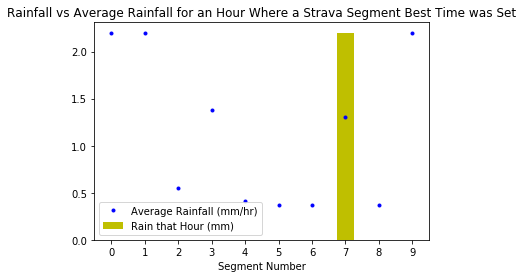

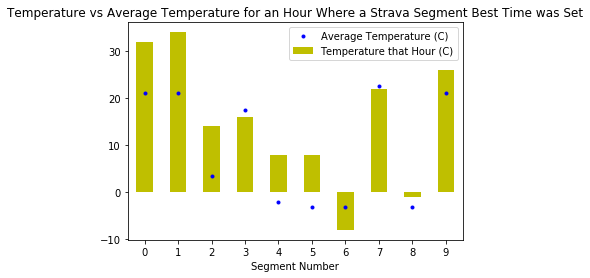

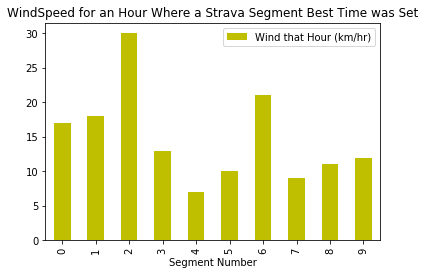

In [54]:
plt.figure()
plt.title("Rainfall vs Average Rainfall for an Hour Where a Strava Segment Best Time was Set")
plt.xlabel("Segment Number")
consolidated_df['Rain that Hour (mm)'].plot(kind='bar', color='y', label='df1')
consolidated_df['Average Rainfall (mm/hr)'].plot(style='.', color='b', label='df2').legend(['Average Rainfall (mm/hr)', 'Rain that Hour (mm)'])

plt.figure()
plt.title("Temperature vs Average Temperature for an Hour Where a Strava Segment Best Time was Set")
plt.xlabel("Segment Number")
consolidated_df['Temperature that Hour (C)'].plot(kind='bar', x='Segment Name', color='y')
consolidated_df['Average Temperature (C)'].plot(style='.', color='b').legend(['Average Temperature (C)', 'Temperature that Hour (C)'])

plt.figure()
plt.title("WindSpeed for an Hour Where a Strava Segment Best Time was Set")
plt.xlabel("Segment Number")
consolidated_df['Wind that Hour (km/hr)'].plot(kind='bar', x='Segment Name', color='y').legend(['Wind that Hour (km/hr)'])

Plots of each weather feature on the day vs the average speed during that segment run

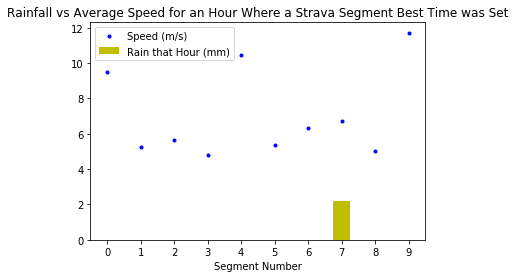

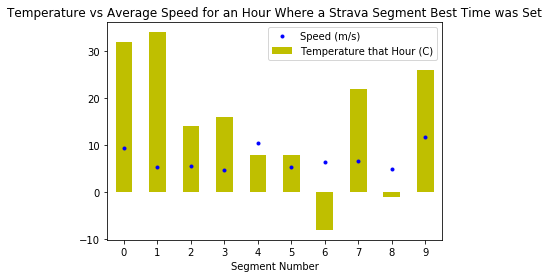

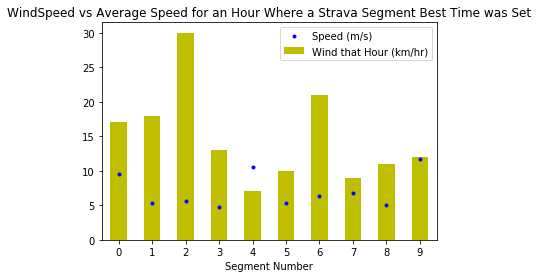

In [55]:
plt.figure()
plt.xlabel("Segment Number")
plt.title("Rainfall vs Average Speed for an Hour Where a Strava Segment Best Time was Set")
consolidated_df['Rain that Hour (mm)'].plot(kind='bar', x='Segment Name', color='y')
consolidated_df['Speed (m/s)'].plot(style='.', color='b').legend(['Speed (m/s)','Rain that Hour (mm)'])

plt.figure()
plt.title("Temperature vs Average Speed for an Hour Where a Strava Segment Best Time was Set")
plt.xlabel("Segment Number")
consolidated_df['Temperature that Hour (C)'].plot(kind='bar', x='Segment Name', color='y', legend=True)
consolidated_df['Speed (m/s)'].plot(style='.', color='b').legend(['Speed (m/s)','Temperature that Hour (C)'])

plt.figure()
plt.title("WindSpeed vs Average Speed for an Hour Where a Strava Segment Best Time was Set")
plt.xlabel("Segment Number")
consolidated_df['Wind that Hour (km/hr)'].plot(kind='bar', x='Segment Name', color='y', legend=True)
consolidated_df['Speed (m/s)'].plot(style='.', color='b').legend(['Speed (m/s)','Wind that Hour (km/hr)'])

Finally I had planned on plotting the average heart rate of the athlete as a function of the weather to see if there was
any significant relationship here. According to the API, [the SegmentLeaderboardEntry has an attribute 'average_hr'.](https://pythonhosted.org/stravalib/api.html?highlight=get_segment_leaderboard#stravalib.model.SegmentLeaderboardEntry)
This is not the case in object returned from the API today. It appears others using the API have had [similar problems.](https://groups.google.com/forum/#!topic/strava-api/SsL2ytxtZng)

# Conclusions
Rain looks to play a significant role in the setting of a fastest segment time as on nine of the ten days where a fastest
time was set there was no rain during that hour. The one outlier is interesting as not only did it rain that hour, it rained
at a rate that was above average for that hour.

The temperature at which a fastest time is set has a difference of 42 degrees (min of -8 and max of 34). By looking at this data
and the graph plotting the speed vs the average temperature for the hour, you can see that the temperature fluctuates wildly while
the average speed stays the same. This leads to the conclusion that temperature is the least significant weather factor in
setting a fastest Strava segment time.

Low wind seams to have an impact with a min of 7km/hr and a max of 30km/hr. According to the [Beaufort scale](https://en.wind-turbine-models.com/winds)
these wind rates range from a 'Light breeze' to a 'Fresh breeze'. This conclusion needed some domain specific knowledge
on wind speeds as from the graph it looks like there is little to no relationship here.

__NOTE:__ The data gathered here is from Galway City and its surrounding areas.